In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
iris = load_iris()
X = iris.data 
y = iris.target 

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)
print("Unique class labels:", np.unique(y))
print("Class names:", iris.target_names)


Feature matrix shape: (150, 4)
Labels shape: (150,)
Unique class labels: [0 1 2]
Class names: ['setosa' 'versicolor' 'virginica']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 90
Test set size: 60


# No Preprocessing

In [8]:
X_train_none = X_train.copy()
X_test_none = X_test.copy()

# Min - Max normalisation

In [9]:
X_min = np.min(X_train, axis=0)
X_max = np.max(X_train, axis=0)

X_train_minmax = (X_train - X_min) / (X_max - X_min)
X_test_minmax = (X_test - X_min) / (X_max - X_min)


# Standardization

In [10]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train_std = (X_train - mean) / std
X_test_std = (X_test - mean) / std

# Softmax function

In [45]:
def softmax(logits):
    exp_vals = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return exp_vals / np.sum(exp_vals, axis=1, keepdims=True)


In [ ]:
def cross_entropy_loss(y_true, y_pred):
    eps = 1e-8 
    y_pred_clipped = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(np.sum(y_true * np.log(y_pred_clipped), axis=1))


In [ ]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

num_classes = len(np.unique(y)) 
y_train_oh = one_hot_encode(y_train, num_classes)
y_test_oh  = one_hot_encode(y_test, num_classes)


# Batch Gradient Descent Function

In [ ]:
def train_logreg_batch(X_train, y_train_oh, lr=0.05, epochs=200):
    m, n_features = X_train.shape
    _, n_classes  = y_train_oh.shape
    
    np.random.seed(0)
    W = np.random.randn(n_features, n_classes) * 0.01
    b = np.zeros((1, n_classes))
    
    loss_history = []
    
    for epoch in range(epochs):
        # Forward
        logits = X_train.dot(W) + b     
        probs = softmax(logits)           
        
        # Loss
        loss = cross_entropy_loss(y_train_oh, probs)
        loss_history.append(loss)
        
        # Backprop
        dZ = probs - y_train_oh          
        dW = (1/m) * X_train.T.dot(dZ)    
        db = (1/m) * np.sum(dZ, axis=0, keepdims=True)  
        
        # Update
        W -= lr * dW
        b -= lr * db
        
        if (epoch+1) % 50 == 0:
            print(f"[Batch GD] Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}")
    
    return W, b, loss_history


# Stochastic Gradient Descent Function

In [ ]:
def train_logreg_sgd(X_train, y_train_oh, lr=0.01, epochs=10):
    m, n_features = X_train.shape
    _, n_classes  = y_train_oh.shape
    
    np.random.seed(1)
    W = np.random.randn(n_features, n_classes) * 0.01
    b = np.zeros((1, n_classes))
    
    loss_history = []
    
    for epoch in range(epochs):
        indices = np.arange(m)
        np.random.shuffle(indices)
        
        epoch_loss = 0.0
        
        for i in indices:
            x_i = X_train[i].reshape(1, -1)    
            y_i = y_train_oh[i].reshape(1, -1) 
            # Forward
            logits = x_i.dot(W) + b           
            probs = softmax(logits)           
            
            # Loss 
            loss = cross_entropy_loss(y_i, probs)
            epoch_loss += loss
            
            # Backprop
            dZ = probs - y_i                 
            dW = x_i.T.dot(dZ)                
            db = dZ                          
            
            # Update
            W -= lr * dW
            b -= lr * db
        
        # Average loss in epoch
        avg_loss = epoch_loss / m
        loss_history.append(avg_loss)
        
        if (epoch+1) % 2 == 0:
            print(f"[SGD] Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
    
    return W, b, loss_history


In [ ]:
def predict(X, W, b):
    logits = X.dot(W) + b
    probs = softmax(logits)
    return np.argmax(probs, axis=1) 


In [22]:
def evaluate_model(X_test, y_test, W, b):
    y_pred = predict(X_test, W, b)
    accuracy = np.mean(y_pred == y_test)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", cr)
    
    return accuracy, cm, cr


# Model Running and Evaluation

In [ ]:
def run_experiment(X_train_preproc, X_test_preproc, y_train_oh, y_test, method_name):
    print(f"\n=== {method_name} ===")
    
    # Batch Gradient Descent
    W_batch, b_batch, loss_batch = train_logreg_batch(
        X_train_preproc, y_train_oh, lr=0.1, epochs=300
    )
    print(f"{method_name} (Batch GD) - Final Loss: {loss_batch[-1]:.4f}")
    print(f"\n{method_name} (Batch GD) EVALUATION:")
    acc_batch, cm_batch, cr_batch = evaluate_model(X_test_preproc, y_test, W_batch, b_batch)
    
    # Stochastic Gradient Descent
    W_sgd, b_sgd, loss_sgd = train_logreg_sgd(
        X_train_preproc, y_train_oh, lr=0.02, epochs=200
    )
    print(f"{method_name} (SGD) - Final Loss: {loss_sgd[-1]:.4f}")
    
    print(f"\n{method_name} (SGD) EVALUATION:")
    acc_sgd, cm_sgd, cr_sgd = evaluate_model(X_test_preproc, y_test, W_sgd, b_sgd)
    return (loss_batch, loss_sgd)

# for each type of preprocessing
loss_none_batch, loss_none_sgd = run_experiment(X_train_none, X_test_none, y_train_oh, y_test, "No Preprocessing")
loss_minmax_batch, loss_minmax_sgd = run_experiment(X_train_minmax, X_test_minmax, y_train_oh, y_test, "Min-Max Normalization")
loss_std_batch, loss_std_sgd = run_experiment(X_train_std, X_test_std, y_train_oh, y_test, "Standardization")



=== No Preprocessing ===
[Batch GD] Epoch 50/300 - Loss: 0.6382
[Batch GD] Epoch 100/300 - Loss: 0.4602
[Batch GD] Epoch 150/300 - Loss: 0.3133
[Batch GD] Epoch 200/300 - Loss: 0.2549
[Batch GD] Epoch 250/300 - Loss: 0.2316
[Batch GD] Epoch 300/300 - Loss: 0.2136
No Preprocessing (Batch GD) - Final Loss: 0.2136

No Preprocessing (Batch GD) EVALUATION:
Accuracy: 0.9666666666666667
Confusion Matrix:
 [[20  0  0]
 [ 0 18  2]
 [ 0  0 20]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      0.90      0.95        20
           2       0.91      1.00      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60

[SGD] Epoch 2/200 - Loss: 0.7338
[SGD] Epoch 4/200 - Loss: 0.5571
[SGD] Epoch 6/200 - Loss: 0.4474
[SGD] Epoch 8/200 - Loss: 0.3778
[SGD] Epoch 10/200 - Lo

# Training Performance

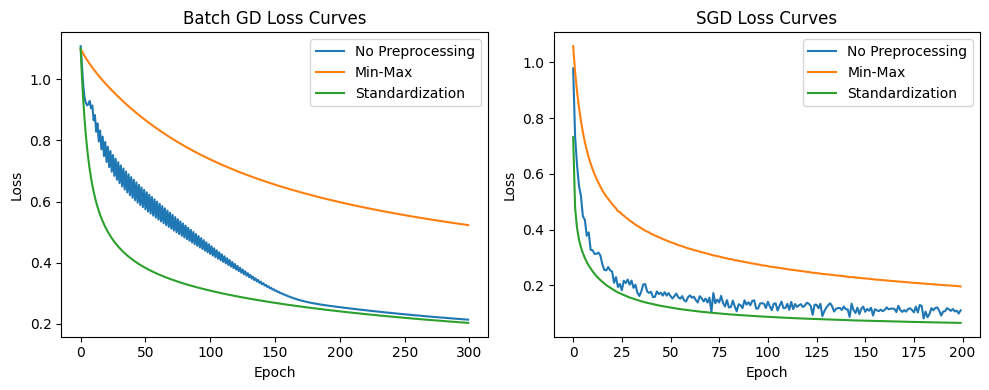

In [ ]:
plt.figure(figsize=(10,4))

# Batch Gradient Descent Loss
plt.subplot(1, 2, 1)
plt.plot(loss_none_batch, label="No Preprocessing")
plt.plot(loss_minmax_batch, label="Min-Max")
plt.plot(loss_std_batch, label="Standardization")
plt.title("Batch GD Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Stochastic Gradient Descent Loss
plt.subplot(1, 2, 2)
plt.plot(loss_none_sgd, label="No Preprocessing")
plt.plot(loss_minmax_sgd, label="Min-Max")
plt.plot(loss_std_sgd, label="Standardization")
plt.title("SGD Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
